# Localization with a known map  - Tutorial: Part 1

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.



In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
#nbx --fname="src/localization_part_1.jl"
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools;
using CUDA
using LaTeXStrings
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt # Python-style f-strings
using MyUtils
using StatsBase: mean
using Random: shuffle
include("../src/pose.jl");
include("src/plotting.jl");

In [3]:
# Load the environment and poses
include("src/house_expo_data.jl");

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64


In [ ]:
# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Cluttered Environment and Path")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:magenta)
plot!(_ps, c=col[1])

Note that the data does not contain any measurement data. We are going take those measurement ourselves. To do so
let's include some files with deterministic depth sensors so we can make measurements. 

In [4]:
include("../src/cuda_raycaster_line_map_b.jl")

_fov = 2π
_num_a = 361
_as  = [range(-_fov/2, _fov/2, _num_a)...];

_segs_  = CuArray(stack(Vector.(_segs)));
_boxes_ = CuArray(stack(Vector.(_boxes)));
_ps_    = CuArray(stack(Vector.(_ps)));
_as_    = CuArray(_as);


# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
zs_ = cast_cu(_ps_, vcat(_segs_, _boxes_); fov=_fov)
_zs = unstack(Array(zs_));
_ys = [polar_inv(z,_as) for z in _zs]

print("""
_segs_   $(typeof(_segs_)) 
_boxes_  $(typeof(_boxes_)) 
_ps_     $(typeof(_ps_)) 
_as_     $(typeof(_as_)) 

_fov     $(typeof(_fov)) 
_as      $(typeof(_as))
_zs      $(typeof(_zs)) 
_ys      $(typeof(_ys)) 
""")

_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer} 
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer} 

_fov     Float64 
_as      Vector{Float64}
_zs      Vector{Vector{Float64}} 
_ys      Vector{Vector{Vector{Float64}}} 


In [ ]:
t = 10
p = _ps[t]
y = _ys[t]

# -----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing, title="Measurements")
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black)
scatter!(p, c=:red, r=1.0, linewidth=2)
scatter!(shuffle(y[1:2:end]).*p, c=:magenta, markersize=4, alpha=.7, markerstrokewidth=1)

## Model parts

A couple of distributions we need down the line: a diagonal normal distribution `diagnormal` and a multivariate uniform distribution `mvuniform`.

In [5]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(2), ones(2))

2-element Vector{Float64}:
 0.8031969410448682
 0.4422701788700767

### Pose-prior model

In [6]:
#nbx
"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_bb`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

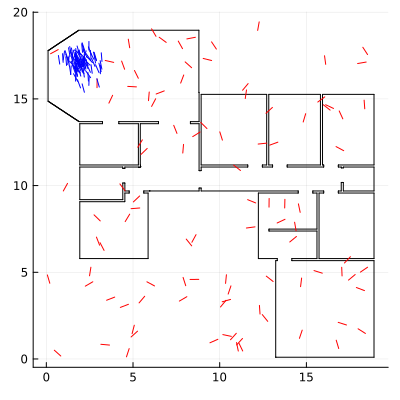

In [ ]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:100]

# ----------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

We don't use the prior at the moment. We assume the controls are given.

In [7]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

### Motion model

In [8]:
#nbx
"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;

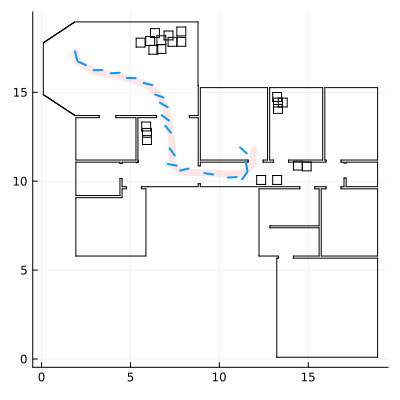

In [ ]:
ps = Pose[_ps[1]]

for u in _us
    p = motion_model(ps[end], u, 1e-1, 2\pi * 1e-1)       
    push!(ps, p)
end
ps = [p for p in ps]

# ---------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black, linewidth=1)
plot!(_boxes, c=:black, linewidth=1)
plot!([p.x for p in _ps], c=:red, linewidth=7, alpha=0.1)
plot!(ps, c=col[1], linewidth=2)

### Sensor model

In [9]:
#nbx
include("src/sensor_distribution.jl")

In [25]:
# Todo: Maybe call it PerformanceWrapper?
mutable struct DistributionWrapper{T} <: Distribution{T}
    d::Distribution{T}
    argtransform
    logpdf
    random
end
DistributionWrapper(d) = DistributionWrapper(d, args -> args, nothing, nothing)

function Gen.random(Q::DistributionWrapper, args...)
    args = Q.argtransform == nothing ?  args : Q.argtransform(args);
    return Q.random == nothing ? Gen.random(Q.d, args...) : Q.random(args...);
end
(Q::DistributionWrapper)(args...) = Gen.random(Q::DistributionWrapper, args...)

function Gen.logpdf(Q::DistributionWrapper, x, args...)
    # args = Q.argtransform == nothing ?  args : Q.argtransform(args);
    return Q.logpdf == nothing ? Gen.logpdf(Q.d,x, args...) : Q.logpdf(x,args...);
end
function Gen.logpdf_grad(Q::DistributionWrapper, x, args...)
    args = Q.argtransform == nothing ?  args : Q.argtransform(args);
    return Gen.logpdf_grad(Q.d, x, Q.argtransform(args)...)
end
Gen.has_output_grad(Q::DistributionWrapper)    = Gen.has_output_grad(Q.d)
Gen.has_argument_grads(Q::DistributionWrapper) = Gen.has_argument_grads(Q.d)

In [26]:
d = DistributionWrapper(normal);
@btime Gen.logpdf(d,0.0,0,1) samples=5 evals=5;
@btime Gen.logpdf(normal,0.0,0,1) samples=5 evals=5;

  458.800 ns (5 allocations: 96 bytes)
  126.000 ns (0 allocations: 0 bytes)


In [ ]:
n = 1000
m = 2000
@btime fill(0.3, n,m) samples=5;
@btime 0.3*ones(n,m)  samples=5;

  2.094 ms (2 allocations: 15.26 MiB)
  5.083 ms (4 allocations: 30.52 MiB)


In [ ]:
gm             = HomogeneousMixture(diagnormal, [1, 1])
outlier_dist   = diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = DistributionWrapper(ProductDistribution(sensor_mix))

function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

@btime logpdf(sensor_product, x, args...) samples=3 evals=3;

  16.332 ms (161737 allocations: 5.66 MiB)


In [ ]:
function sensor_product_logpdf(x, args...)
    return -Inf
end
sensor_product.logpdf = function (x, args...)
    
@btime logpdf(sensor_product, x, args...) samples=3 evals=3;

  669.333 ns (1 allocation: 32 bytes)


In [ ]:


w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax = 100.0

m = 4
ws = ones(m)
ws = ws ./ sum(ws)
mus  = rand(2,m)
stds = 0.01*ones(2,m)

gm(ws, mus, stds)


function fill_with_args(n, args...)
    return [fill(a, n) for a in args]
end

function sensor_mix_args(ỹ, sig, outlier, outlier_vol, zmax)
    m, = size(ỹ,1)

    args = (
        [1-outlier, outlier], 
        ones(m)./m , 
        ỹ', 
        ones(2,m)*sig, 
        [0.0;0.0], 
        [zmax;zmax]
    )
    return args
end

sensor_mix_args (generic function with 1 method)

In [ ]:
#nbx
@gen function sensor_model_v0(p, segs_, w, sig, outlier, outlier_vol, zmax)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    zs_ = cast_cu(ps_, segs_; fov=_fov)
    
    ỹ_ = get_ys_tilde_cu(zs_, _as_, w)[1,:,:,:]
    ỹ  = Array(ỹ_)
    n,m, = size(ỹ)

    x = []
    for i=1:n
        x_i = {i} ~ sensor_mix(sensor_mix_args(ỹ[i,:,:], sig, outlier, outlier_vol, zmax)...)
        push!(x,x_i)
    end    
    return x
end;

#nbx
@gen function sensor_model_v1(p, segs_, w, sig, outlier, outlier_vol, zmax)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    zs_ = cast_cu(ps_, segs_; fov=_fov)
    
    ỹ_ = get_ys_tilde_cu(zs_, _as_, w)[1,:,:,:]
    ỹ  = Array(ỹ_)
    n,m, = size(ỹ)

    ỹ_perm = permutedims(ỹ, (1,3,2))

    ws = ones(m) ./ m
    x ~ sensor_product(fill([1-outlier, outlier],n),fill(ws,n), ỹ_perm, sig*ones(n,2,m), zeros(n,2), zmax*ones(n,2))
    return x
end;

In [ ]:
t = 7

p  = _ps[t]
m_ = vcat(_segs_, _boxes_)

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax = 100.0


args  = (p, m_, w, s_noise, outlier, outliver_vol, zmax)
sensor_model_v0(args...)
tr = simulate(sensor_model_v0, args)

sensor_model_v1(args...)
tr = simulate(sensor_model_v0, args)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##sensor_model_v0#1110", Bool[0, 0, 0, 0, 0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(56 => Gen.ChoiceOrCallRecord{Vector{Float64}}([-3.1117124436184156, -4.976531307926546], -0.714475836222014, NaN, true), 35 => Gen.ChoiceOrCallRecord{Vector{Float64}}([-5.673028126962417, -3.481583361989042], -1.0854246676336337, NaN, true), 60 => Gen.ChoiceOrCallRecord{Vector{Float64}}([-3.39198081404904, -4.878156291290653], -1.8189419645513227, NaN, true), 220 => Gen.ChoiceOrCallRecord{Vector{Float64}}([1.6686341834778093, 1.6958874708516167], 0.45572866670066436, NaN, true), 308 => Gen.ChoiceOrCallRecord{Vector{Float64}}([-1.517219618778187, 2.693543006546148], -0.4038652920137141, NaN, true), 67 => Gen.Choi

In [ ]:
t = 7

p  = _ps[t]
m_ = vcat(_segs_, _boxes_)

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100


args  = (p, m_, w, s_noise, outlier, outlier_vol, zmax)
tr = simulate(sensor_model_v0, args)
x = tr[];
n = length(_as)
ch = choicemap([i => x[t] for i=1:n]...)

@btime sensor_model_v0(args...) samples=3 evals=3;
@btime simulate(sensor_model_v0, args) samples=3 evals=3;
@btime generate(sensor_model_v0, args, ch) samples=5 evals=5;

@btime sensor_model_v1(args...) samples=3 evals=3;
@btime simulate(sensor_model_v1, args) samples=3 evals=3;
@btime generate(sensor_model_v1, args, ch) samples=5 evals=5;

  1.593 ms (13444 allocations: 873.48 KiB)
  12.520 ms (109678 allocations: 3.95 MiB)
  10.926 ms (100926 allocations: 3.58 MiB)
  2.394 ms (15939 allocations: 990.11 KiB)
  11.509 ms (107624 allocations: 4.08 MiB)
  11.807 ms (107582 allocations: 4.08 MiB)


In [ ]:
#nbx
@gen function sensor_model_cu(p, segs_, w, s_noise, outlier, outlier_vol)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    zs_ = cast_cu(ps_, segs_; fov=_fov)
    
    y_tilde_ = get_ys_tilde_cu(zs_, _as_, w)[1,:,:,:]

    n,m, = size(y_tilde_)

    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outlier_vol)
    
    return x
end;

  11.761 ms (16991 allocations: 791.21 KiB)
  12.580 ms (17681 allocations: 849.23 KiB)
  788.034 μs (1001 allocations: 74.16 KiB)


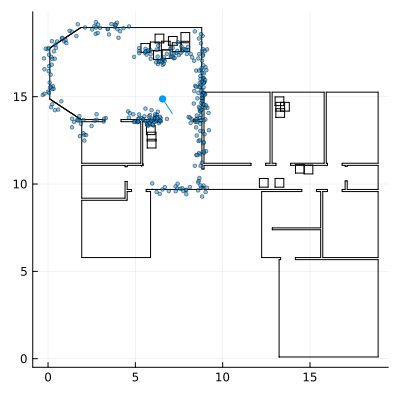

In [ ]:
t = 7

p  = _ps[t]
m_ = vcat(_segs_, _boxes_)

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0

args  = (p, m_, w, s_noise, outlier, outliver_vol)

tr = simulate(sensor_model_cu, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model_cu(args...) samples=3 evals=3;
@btime simulate(sensor_model_cu, args) samples=3 evals=3;
@btime generate(sensor_model_cu, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:black)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
scatter!(_ps[t], c=col[1])

In [ ]:
sensor_model = sensor_model_v0

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing], var"##sensor_model_v0#1045", Bool[0, 0, 0, 0, 0, 0, 0], false)